In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']= '/content/'

In [ ]:
!kaggle competitions download -c dogs-vs-cats


100% 809M/812M [00:42<00:00, 21.7MB/s]
100% 812M/812M [00:42<00:00, 20.0MB/s]


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!unzip -q dogs-vs-cats.zip

In [ ]:
!unzip -q train.zip

In [ ]:
data = pd.DataFrame(columns=['filename','label'])
data['filename']= os.listdir('train/')

In [ ]:
data['label'] = data['filename'].str.split(".",expand= True)[0]

In [ ]:
data.sample(5)

,filename,label
6550,dog.6442.jpg,dog
24015,dog.9356.jpg,dog
22421,cat.787.jpg,cat
7170,cat.1485.jpg,cat
3257,cat.6092.jpg,cat


In [ ]:
# VGG Pre Processing
! wget https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg

--2023-08-12 06:47:01--  https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229955 (225K) [image/jpeg]
Saving to: ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’

dog-puppy-on-garden 100%[===================>] 224.57K  --.-KB/s    in 0.003s  

2023-08-12 06:47:01 (63.8 MB/s) - ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’ saved [229955/229955]



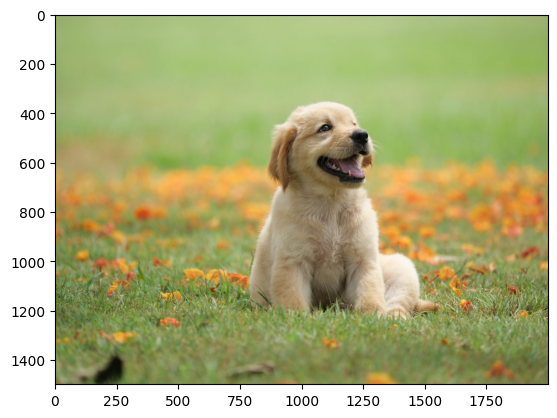

In [ ]:
image = tf.keras.preprocessing.image.load_img("dog-puppy-on-garden-royalty-free-image-1586966191.jpg")
plt.imshow(image)
# image

In [ ]:
image_arr = tf.keras.preprocessing.image.img_to_array(image)
type(image_arr), image_arr.shape

(numpy.ndarray, (1499, 1999, 3))

In [ ]:
image_pre = tf.keras.applications.vgg16.preprocess_input(image_arr)
image_pre.shape

(1499, 1999, 3)

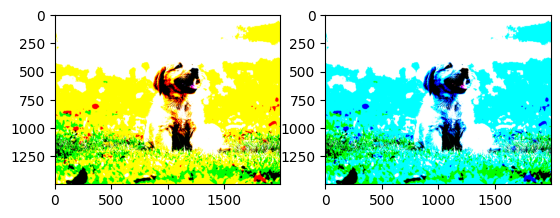

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_arr)
plt.subplot(1,2,2)
plt.imshow(image_pre)

In [ ]:
# We cant rescale this time, VGG is built on someother preprocessing (standard scaler)
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                                      validation_split=0.1)

In [ ]:
batch_size=64
train_idg = idg.flow_from_dataframe(data, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=(300, 300), subset="training")

Found 22500 validated image filenames belonging to 2 classes.


In [ ]:
val_idg= idg.flow_from_dataframe(data,"train/",x_col='filename',y_col='label',
                                 batch_size=batch_size,
                                 target_size=(300,300),subset="validation")

Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(300, 300, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
# How do we make sure, that BP doesnt update the filter of our Conv Layers
# by deafult all layers are set to be trainable, and we need to stop for VGG's Conv layer
for layer in vgg16_model.layers:
  print(layer.name, layer.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
for layer in vgg16_model.layers:
  layer.trainable = False

In [ ]:
for layer in vgg16_model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
#Functional Model
flat = tf.keras.layers.Flatten(name='Flatten_Layer')(vgg16_model.output)
dense1 = tf.keras.layers.Dense(128,activation="relu")(flat)
output = tf.keras.layers.Dense(2,activation="softmax")(dense1)

In [ ]:
final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output] )

In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

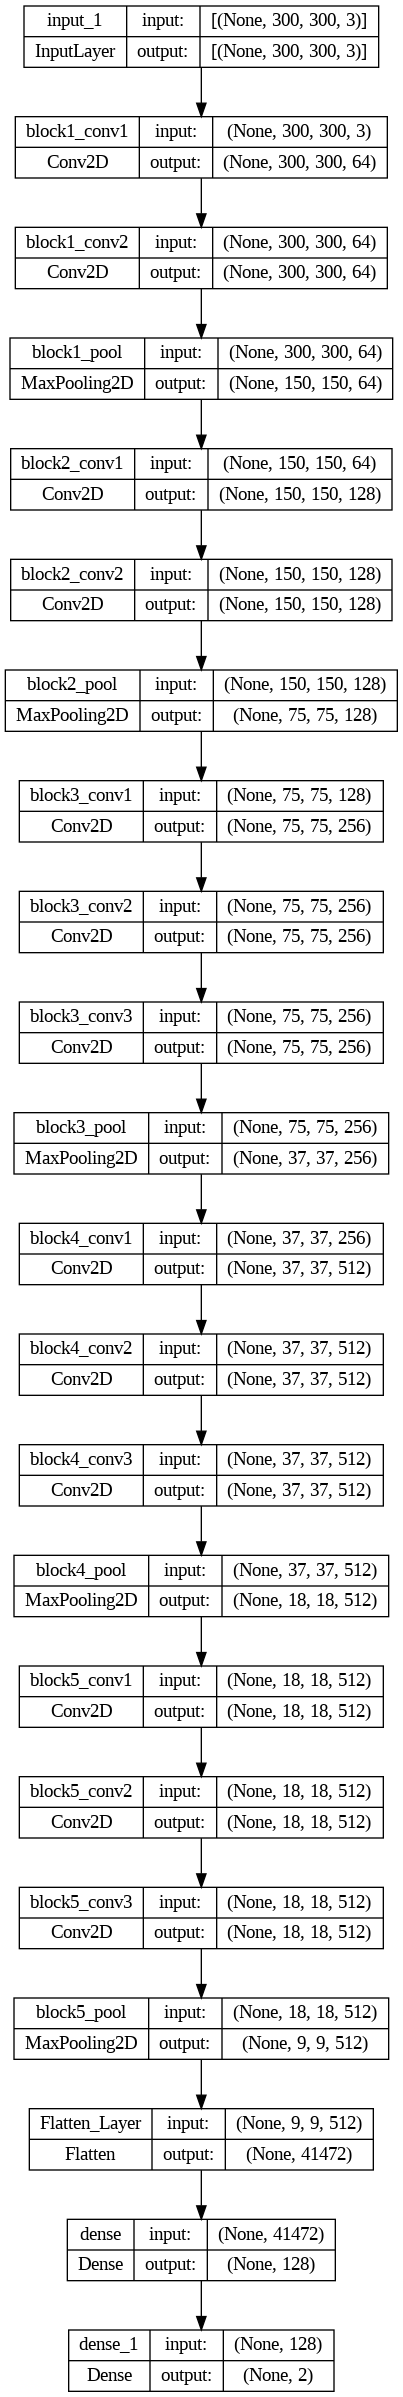

In [ ]:
tf.keras.utils.plot_model(final_model,show_shapes= True,show_layer_names=True)

In [ ]:
final_model.compile(optimizer= tf.keras.optimizers.SGD(),
                    loss= tf.keras.losses.categorical_crossentropy,
                    metrics=['acc'])

In [ ]:
final_model.fit(train_idg,batch_size = batch_size, validation_data=val_idg,epochs=10)

Epoch 1/10
352/352 [==============================] - 228s 580ms/step - loss: 5.4030 - acc: 0.9716 - val_loss: 0.0438 - val_acc: 0.9884
Epoch 2/10
352/352 [==============================] - 200s 568ms/step - loss: 0.0149 - acc: 0.9949 - val_loss: 0.0480 - val_acc: 0.9880
Epoch 3/10
352/352 [==============================] - 200s 568ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0547 - val_acc: 0.9860
Epoch 4/10
352/352 [==============================] - 203s 577ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0527 - val_acc: 0.9888
Epoch 5/10
352/352 [==============================] - 201s 570ms/step - loss: 9.0529e-04 - acc: 0.9998 - val_loss: 0.0590 - val_acc: 0.9884
Epoch 6/10
352/352 [==============================] - 200s 567ms/step - loss: 6.5265e-04 - acc: 0.9998 - val_loss: 0.0603 - val_acc: 0.9900
Epoch 7/10
352/352 [==============================] - 200s 567ms/step - loss: 5.8121e-04 - acc: 0.9998 - val_loss: 0.0627 - val_acc: 0.9900
Epoch 8/10
352/352 [================

Text(0.5, 1.0, 'Accuracy of Model')

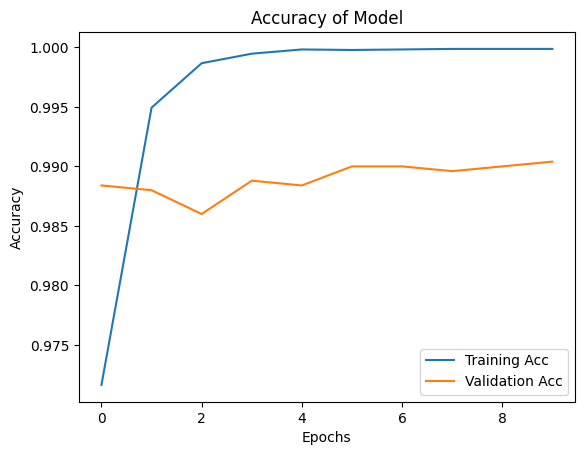

In [ ]:
#Plotting Acc vs Val Graph
plt.plot(final_model.history.history['acc'],label='Training Acc')
plt.plot(final_model.history.history['val_acc'],label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy of Model")

Text(0.5, 1.0, 'Losses of Model')

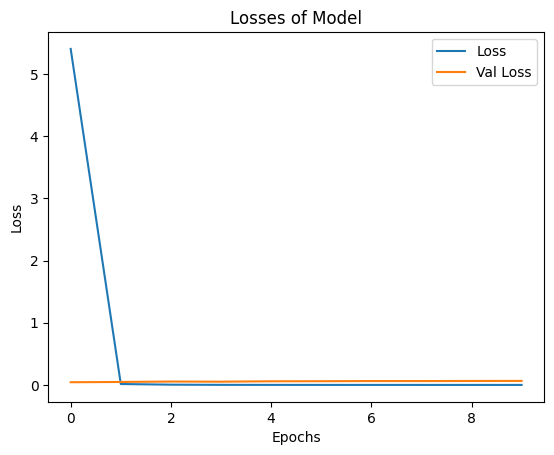

In [ ]:
#Plotting Losses (In DL We focus on Losses over accuracy)
plt.plot(final_model.history.history['loss'],label='Loss')
plt.plot(final_model.history.history['val_loss'],label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses of Model')

In [ ]:
#validation loss is increasing very slowly , however the validation accuracy increases and after 6th epoch it reaches a constant value of 0.9844.
#Huge variance in acc and val acc.    loss: 6.1498e-04 - acc: 0.9993 - val_loss: 0.0910 - val_acc: 0.9844


**Testing the model on unseen data from internet**

In [ ]:
!wget https://dogtime.com/wp-content/uploads/sites/12/2023/07/GettyImages-556452601.jpg

--2023-08-12 07:25:03--  https://dogtime.com/wp-content/uploads/sites/12/2023/07/GettyImages-556452601.jpg
Resolving dogtime.com (dogtime.com)... 104.17.70.15, 104.17.69.15, 2606:4700::6811:460f, ...
Connecting to dogtime.com (dogtime.com)|104.17.70.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85248 (83K) [image/webp]
Saving to: ‘GettyImages-556452601.jpg’

GettyImages-5564526 100%[===================>]  83.25K  --.-KB/s    in 0.002s  

2023-08-12 07:25:04 (44.6 MB/s) - ‘GettyImages-556452601.jpg’ saved [85248/85248]



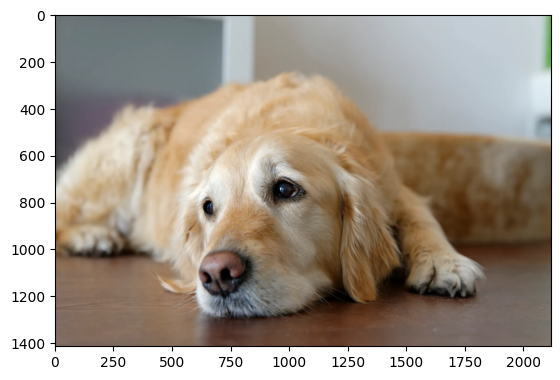

In [ ]:
# Plotting Image
image = tf.keras.preprocessing.image.load_img('GettyImages-556452601.jpg')
plt.imshow(image)

In [ ]:
image_arr = tf.keras.preprocessing.image.img_to_array(image)
type(image_arr), image_arr.shape

(numpy.ndarray, (1414, 2119, 3))

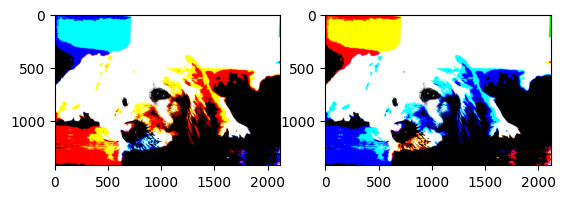

In [ ]:
image_pre = tf.keras.applications.vgg16.preprocess_input(image_arr)
image_pre.shape
plt.subplot(1,2,1)
plt.imshow(image_arr)
plt.subplot(1,2,2)
plt.imshow(image_pre)

In [ ]:
test_image = np.expand_dims(image_pre,axis=0)

In [ ]:
test_image.shape

(1, 1414, 2119, 3)

In [ ]:
# Preprocess and load test data
test_image_path = 'GettyImages-556452601.jpg'
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (300, 300))
test_image = tf.keras.applications.vgg16.preprocess_input(test_image)

# Expand dimensions to match the expected input shape of the model
test_image = np.expand_dims(test_image, axis=0)

# Get predictions
predictions = final_model.predict(test_image)

1/1 [==============================] - 1s 774ms/step


In [ ]:
# Get the model's prediction
prediction = final_model.predict(test_image)

# Print the raw prediction
print("Raw Prediction:", prediction)

# Convert the prediction to class label
if prediction[0][0] > prediction[0][1]:
    class_label = 'Cat'
else:
    class_label = 'Dog'

# Print the predicted class
print("Predicted class:", class_label)

1/1 [==============================] - 0s 30ms/step
Raw Prediction: [[1.6503787e-27 1.0000000e+00]]
Predicted class: Dog


*Our Model Correctly predicts the do image with an accuracy of 100%*

**Test Directory**

In [ ]:
!unzip -q test1.zip

In [ ]:
len(os.listdir("test1"))

12500

In [ ]:
test_data = pd.DataFrame(columns=["filename","labels"])
test_data['filename']= os.listdir("test1/")

In [ ]:
test_data.sample(5)

,filename,labels
3534,401.jpg,NaN
3964,5344.jpg,NaN
4375,6714.jpg,NaN
1758,2464.jpg,NaN
10318,2713.jpg,NaN


In [ ]:
# Directory containing test images
test_dir = '/content/test1'

# List to store predictions and filenames
predictions = []
filenames = []

# Iterate through the test images
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)

    # Read and preprocess the image
    image = cv2.imread(img_path)
    image = cv2.resize(image, (300, 300))  # Resize to match input size of your model
    image = tf.keras.applications.vgg16.preprocess_input(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    prediction = final_model.predict(image)

    # Convert prediction to class label
    if prediction[0][0] > prediction[0][1]:
        class_label = 'Cat'
    else:
        class_label = 'Dog'

    # Append prediction and filename to lists
    predictions.append(class_label)
    filenames.append(filename)

# Print predictions for each image
for filename, prediction in zip(filenames, predictions):
    print(f"{filename}: {prediction}")


Streaming output truncated to the last 5000 lines.
4477.jpg: Cat
6019.jpg: Dog
11930.jpg: Cat
1538.jpg: Dog
7124.jpg: Cat
2589.jpg: Dog
10416.jpg: Cat
5937.jpg: Cat
1886.jpg: Dog
4333.jpg: Dog
11024.jpg: Dog
3064.jpg: Cat
12439.jpg: Dog
788.jpg: Cat
7786.jpg: Cat
10762.jpg: Cat
539.jpg: Cat
6989.jpg: Cat
8067.jpg: Dog
9178.jpg: Cat
10156.jpg: Cat
7143.jpg: Dog
7741.jpg: Cat
5079.jpg: Cat
8029.jpg: Cat
2030.jpg: Cat
1849.jpg: Dog
6764.jpg: Dog
3581.jpg: Cat
5196.jpg: Cat
6148.jpg: Dog
4988.jpg: Dog
3150.jpg: Dog
5832.jpg: Cat
7139.jpg: Dog
3592.jpg: Dog
6846.jpg: Dog
10049.jpg: Cat
7140.jpg: Cat
1970.jpg: Dog
6749.jpg: Cat
5477.jpg: Cat
8245.jpg: Cat
2339.jpg: Dog
6048.jpg: Cat
2700.jpg: Dog
1040.jpg: Dog
3337.jpg: Cat
9001.jpg: Dog
9186.jpg: Cat
10682.jpg: Cat
5275.jpg: Cat
9966.jpg: Cat
12113.jpg: Dog
4282.jpg: Dog
9388.jpg: Dog
5211.jpg: Cat
4660.jpg: Cat
7753.jpg: Cat
682.jpg: Cat
2506.jpg: Dog
296.jpg: Dog
9360.jpg: Dog
843.jpg: Cat
1642.jpg: Dog
7217.jpg: Cat
306.jpg: Dog
5456.jpg

In [ ]:
#As we can see , our model runs on 12,500 test images and it gives correct predictions for all of them.